In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
%matplotlib inline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize
from sklearn.preprocessing import StandardScaler
from sklearn import neighbors
from sklearn import tree
from sklearn.metrics import precision_score
from sklearn.metrics import confusion_matrix
from sklearn.neural_network import MLPClassifier
from imblearn.over_sampling import SMOTE
from imblearn.ensemble import BalancedRandomForestClassifier

# Лабораторная 1

In [4]:
df = pd.read_csv("credit_card.csv")

Data set: http://archive.ics.uci.edu/ml/datasets/default+of+credit+card+clients
Info: содержит данные о пользователях кредитных карт в Тайване

Task: binary classification, нужно предсказать платежеспособность клиентов (label 1 - заплатил, label 0 - не заплатил)

Atribute Information:
* LIMIT_BAL - сумма кредита (dollars)
* SEX - пол (1 = male, 2 = female)
* EDUCATION - образование (1 = graduate school; 2 = university; 3 = high school; 4 = others)
* MARRIAGE - (1 = married; 2 = single; 3 = others)
* AGE - возраст
* PAY_[ 0,1,2,3,4,5,6 ] (DELAY)  - оплата в 7 предыдущих месяцах
    * -1 = оплатил вовремя
    * 1 = задолжал на 1 месяц
    * ...
    * 9 = задолжал на 9 месяцев и больше
* BILL_AMT[ 0,1,2,3,4,5,6 ] (STATE) - размер счета в каждом месяце
* PAY_AMT[ 0,1,2,3,4,5,6 ] (PAY)  - размер взноса в каждом месяце
* [default payment next month] - заплатит в следующем месяце или нет?

In [5]:
df.shape

(30000, 25)

Данные имеют 30k наблюдений и 24 признака

In [6]:
df.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


Удалим колонку с индексом и переменуем признаки для более удобной работы с ними

In [7]:
df = df.drop(columns=['ID'])
df = df.rename(index=str, columns={"BILL_AMT" + str(i) : "STATE" + str(i)  for i in range(7)})
df = df.rename(index=str, columns={"PAY_AMT" + str(i) : "PAY" + str(i)  for i in range(7)})
df = df.rename(index=str, columns={"PAY_" + str(i) : "DELAY" + str(i)  for i in range(7)})
df = df.rename(index=str, columns={"default payment next month": "label"})

In [8]:
df.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,DELAY0,DELAY2,DELAY3,DELAY4,DELAY5,...,STATE4,STATE5,STATE6,PAY1,PAY2,PAY3,PAY4,PAY5,PAY6,label
0,20000,2,2,1,24,2,2,-1,-1,-2,...,0,0,0,0,689,0,0,0,0,1
1,120000,2,2,2,26,-1,2,0,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,90000,2,2,2,34,0,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,50000,2,2,1,37,0,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,50000,1,2,1,57,-1,0,-1,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


Преобразования прошли успешно, посмотрим на базовые статистики признаков:

In [9]:
df.describe()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,DELAY0,DELAY2,DELAY3,DELAY4,DELAY5,...,STATE4,STATE5,STATE6,PAY1,PAY2,PAY3,PAY4,PAY5,PAY6,label
count,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,...,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.00000,30000.000000,30000.000000,30000.000000,30000.000000
mean,167484.322667,1.603733,1.853133,1.551867,35.485500,-0.016700,-0.133767,-0.166200,-0.220667,-0.266200,...,43262.948967,40311.400967,38871.760400,5663.580500,5.921163e+03,5225.68150,4826.076867,4799.387633,5215.502567,0.221200
std,129747.661567,0.489129,0.790349,0.521970,9.217904,1.123802,1.197186,1.196868,1.169139,1.133187,...,64332.856134,60797.155770,59554.107537,16563.280354,2.304087e+04,17606.96147,15666.159744,15278.305679,17777.465775,0.415062
min,10000.000000,1.000000,0.000000,0.000000,21.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,...,-170000.000000,-81334.000000,-339603.000000,0.000000,0.000000e+00,0.00000,0.000000,0.000000,0.000000,0.000000
25%,50000.000000,1.000000,1.000000,1.000000,28.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,2326.750000,1763.000000,1256.000000,1000.000000,8.330000e+02,390.00000,296.000000,252.500000,117.750000,0.000000
50%,140000.000000,2.000000,2.000000,2.000000,34.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,19052.000000,18104.500000,17071.000000,2100.000000,2.009000e+03,1800.00000,1500.000000,1500.000000,1500.000000,0.000000
75%,240000.000000,2.000000,2.000000,2.000000,41.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,54506.000000,50190.500000,49198.250000,5006.000000,5.000000e+03,4505.00000,4013.250000,4031.500000,4000.000000,0.000000
max,1000000.000000,2.000000,6.000000,3.000000,79.000000,8.000000,8.000000,8.000000,8.000000,8.000000,...,891586.000000,927171.000000,961664.000000,873552.000000,1.684259e+06,896040.00000,621000.000000,426529.000000,528666.000000,1.000000


Самое интересное, что можно подчерпнуть из статистики, что среднее количество нулевых классов - 0.22. Это значит, что классы не сбалансированы, держим это в уме.
Посмотрим корреляцию признаков: 

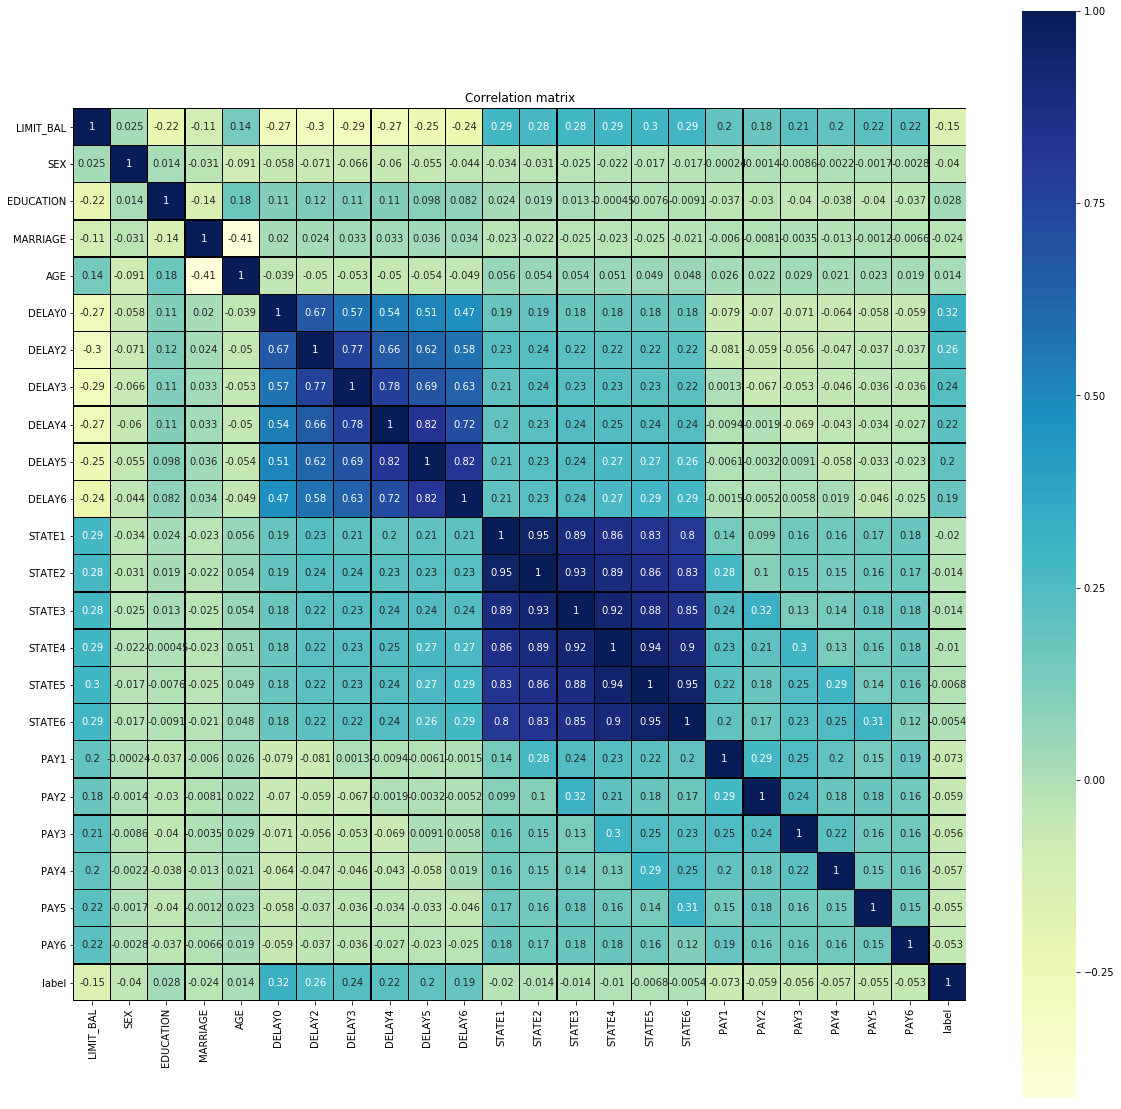

In [10]:
f, ax = plt.subplots(figsize=(20,20))
plt.title('Correlation matrix')
sns.heatmap(df.corr(), linewidths=0.25, vmax=1.0, square=True,
           cmap="YlGnBu", linecolor='black', annot=True)

Делаем следующие выводы:
* Задержки в выплотах(DELAY) в каждем месяце очень сильно зависят друг от друга
* Баланс счета (STATE) так же зависит друг от друга
* Ответ - коррелирует с DELAY, больше остальных признаков. 

Продолжим предобработку данных:
Признаки SEX, EDUCATION, MARRIAGE - категориальные, сделаем их бинаризацию

In [11]:
def do_one_hot_encoding(col, data):
    data = pd.concat([pd.get_dummies(data[col], prefix=col), data],axis=1)
    data.drop([col],axis=1, inplace=True)
    return data

df = do_one_hot_encoding('SEX', df)
df = do_one_hot_encoding('EDUCATION', df)
df = do_one_hot_encoding('MARRIAGE', df)

In [12]:
df.columns

Index(['MARRIAGE_0', 'MARRIAGE_1', 'MARRIAGE_2', 'MARRIAGE_3', 'EDUCATION_0',
       'EDUCATION_1', 'EDUCATION_2', 'EDUCATION_3', 'EDUCATION_4',
       'EDUCATION_5', 'EDUCATION_6', 'SEX_1', 'SEX_2', 'LIMIT_BAL', 'AGE',
       'DELAY0', 'DELAY2', 'DELAY3', 'DELAY4', 'DELAY5', 'DELAY6', 'STATE1',
       'STATE2', 'STATE3', 'STATE4', 'STATE5', 'STATE6', 'PAY1', 'PAY2',
       'PAY3', 'PAY4', 'PAY5', 'PAY6', 'label'],
      dtype='object')

Все на своих местах.

Из корреляционного анализа мы поняли, что признаки - зависимы. Что бы убрать эту зависимость и уменьшить пространство признаков - воспользуемся PCA.

Что бы подобрать оптимальное количество компонент - воспользуемся способом описанным здесь:
https://jakevdp.github.io/PythonDataScienceHandbook/05.09-principal-component-analysis.html

Нам нужно подсчитатать кумулятивную сумму вариации по компонентам.

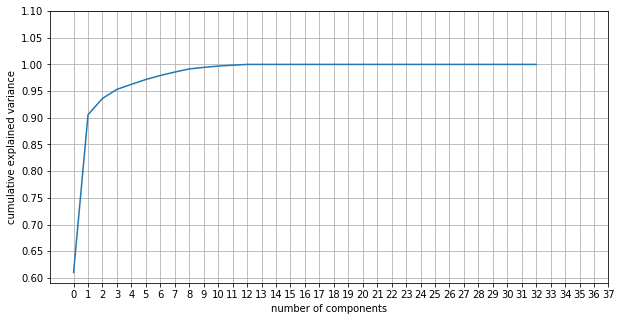

In [13]:
pca = PCA().fit(df.drop(['label'], axis=1))
fig = plt.figure(figsize=(10, 5))
ax = plt.subplot(111)
ax.plot(np.cumsum(pca.explained_variance_ratio_))
ax.set_xticks(np.arange(0,38,1))
ax.set_yticks(np.arange(0.6,1.1,0.05))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');
plt.grid(True)

Видно, что при n_components = 10 мы достигаем практически 100% вариации - остановимся на этом и сделаем трансформацию данных:

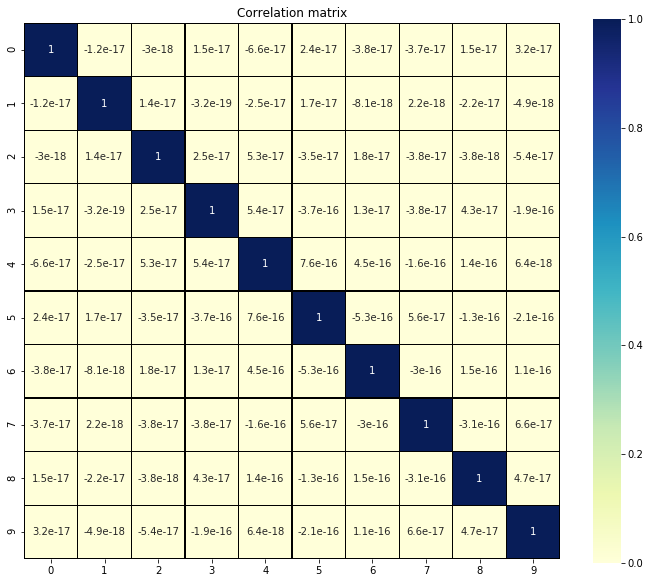

In [14]:
pca = PCA(n_components = 10, random_state=123)
data = pca.fit_transform(df.drop(['label'], axis=1))
f, ax = plt.subplots(figsize=(12,10))
plt.title('Correlation matrix')
sns.heatmap(np.corrcoef(data.T), linewidths=0.25, vmax=1.0, square=True,
           cmap="YlGnBu", linecolor='black', annot=True)

In [15]:
print(df.shape)
print(data.shape)

(30000, 34)
(30000, 10)


Избавились от зависимостей между признаками, теперь разделим дата сет на тренинговый и тестовый. В пропорции - 0.7 и 0.3.

In [16]:
X_train, X_test, y_train, y_test = train_test_split(data, np.array(df['label']), test_size=0.3, random_state=42)

Применим линейную модель для классификации - логистическую регрессию.

In [17]:
%%time
log_reg = LogisticRegression(random_state=0, solver='lbfgs', max_iter=1000)
log_reg.fit(X_train, y_train)
print("train accuracy =", log_reg.score(X_train, y_train))
print("test accuracy  =", log_reg.score(X_test, y_test))

train accuracy = 0.5055714285714286
test accuracy  = 0.5097777777777778
Wall time: 106 ms


Получили плохие очень результаты для бинарной классификации. Одной из причин может быть - не нормализированные данные.
Нормализуем их с помощью Z-Score нормализации.

In [18]:
zscore = StandardScaler()
data_zscore = zscore.fit_transform(df.drop('label', axis=1))

C:\Users\egorsmir\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:617: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\egorsmir\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


Проделаем тот же анализ с PCA:

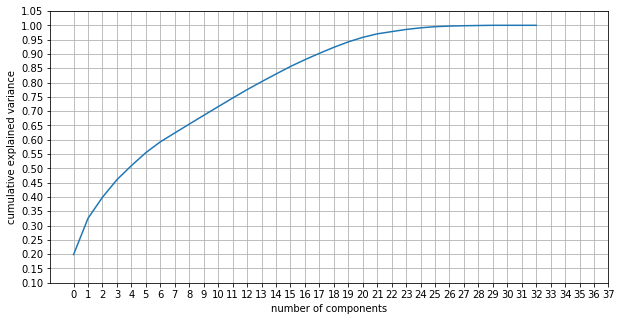

In [19]:
pca = PCA().fit(data_zscore)
fig = plt.figure(figsize=(10, 5))
ax = plt.subplot(111)
ax.plot(np.cumsum(pca.explained_variance_ratio_))
ax.set_xticks(np.arange(0,38,1))
ax.set_yticks(np.arange(0.1,1.1,0.05))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');
plt.grid(True)

Теперь значищих компонент стало намного больше. Выберем значение 19 - находящееся на уровне 95%

In [20]:
pca = PCA(n_components = 19, random_state=123)
data = pca.fit_transform(data_zscore)

In [21]:
X_train, X_test, y_train, y_test = train_test_split(data, np.array(df['label']), test_size=0.3, random_state=42)

In [22]:
%%time
log_reg = LogisticRegression(random_state=0, solver='lbfgs', max_iter=1000)
log_reg.fit(X_train, y_train)
print("train accuracy =", log_reg.score(X_train, y_train))
print("test accuracy  =", log_reg.score(X_test, y_test))

# get_score(log_reg, X_test, y_test)

train accuracy = 0.8042380952380952
test accuracy  = 0.803
Wall time: 79 ms


В этот раз логистическая регрессия показала результаты намного лучше - 80.3% точности. Что говорит о том, что нормализация действительно помогла.

Посмотрим какие результаты будут с другими классификаторами:
Возьмем kNN:

In [25]:
%%time
knn=neighbors.KNeighborsClassifier(n_neighbors=16)
knn.fit(X_train, y_train)
# get_score(knn, X_test, y_test)

print("train accuracy =", knn.score(X_train, y_train))
print("test accuracy  =", knn.score(X_test, y_test))

train accuracy = 0.8189047619047619
test accuracy  = 0.8046666666666666
Wall time: 10.4 s


Точность получается примерно такая-же, однако knn сработал намного медленее.

Решающее дерево:

In [26]:
%%time
dtree = tree.DecisionTreeClassifier()
dtree.fit(X_train, y_train)

print("train accuracy =", dtree.score(X_train, y_train))
print("test accuracy  =", dtree.score(X_test, y_test))

train accuracy = 0.9995238095238095
test accuracy  = 0.711
Wall time: 723 ms


Решающее дерево переобучилось (99% точности на тренинговых данных и 71% на тестовых) - урежем его высоту:

In [27]:
%%time
dtree = tree.DecisionTreeClassifier(max_depth=3)
dtree.fit(X_train, y_train)

print("train accuracy =", dtree.score(X_train, y_train))
print("test accuracy  =", dtree.score(X_test, y_test))

train accuracy = 0.8039047619047619
test accuracy  = 0.7973333333333333
Wall time: 157 ms


Так намного лучше, теперь оно предсказывает с тако-же точностью, что и логистическая регрессия.

Ради эксперемента посмотрим, какие результаты мы получим, если не будем уменьшать пространство признаков с помощью PCA: 

In [28]:
X_train, X_test, y_train, y_test = train_test_split(data_zscore, np.array(df['label']), test_size=0.3, random_state=42)

In [29]:
%%time
log_reg = LogisticRegression(random_state=0, solver='lbfgs', max_iter=1000)
log_reg.fit(X_train, y_train)
print("train accuracy =", log_reg.score(X_train, y_train))
print("test accuracy  =", log_reg.score(X_test, y_test))

train accuracy = 0.8116666666666666
test accuracy  = 0.8095555555555556
Wall time: 113 ms


In [30]:
%%time
knn=neighbors.KNeighborsClassifier(n_neighbors=16)
knn.fit(X_train, y_train)
# get_score(knn, X_test, y_test)

print("train accuracy =", knn.score(X_train, y_train))
print("test accuracy  =", knn.score(X_test, y_test))

train accuracy = 0.8212857142857143
test accuracy  = 0.8076666666666666
Wall time: 1min 1s


In [31]:
%%time
dtree = tree.DecisionTreeClassifier(max_depth=3)
dtree.fit(X_train, y_train)

print("train accuracy =", dtree.score(X_train, y_train))
print("test accuracy  =", dtree.score(X_test, y_test))

train accuracy = 0.8209047619047619
test accuracy  = 0.8205555555555556
Wall time: 110 ms


С одной стороны мы смогли натренировать решающее дерево, которое теперь дает точность предсказания - 82%, с другой стороны время выполнения алгоритмов увеличилось. Например, для kNN c 10s до 1m.

Т.е. применение PCA может сделать как лучше, так и хуже. Зависит от ситуации.

# Лабораторная 2

Прменим нейронные сети для классификации

In [20]:
print(X_train.shape)
print(X_test.shape)

(21000, 19)
(9000, 19)


Выберем топологию нашей MLP. Нужно решить сколько скрытых слоев будет 1 или 2.
Возьмем MLP с одним скрытым слоем и посмотрим на результаты предсказания:

In [21]:
%%time
nn = MLPClassifier(hidden_layer_sizes=(100, ), activation='logistic', batch_size=256, solver='sgd')
nn.fit(X_train, y_train)
print("train accuracy =", nn.score(X_train, y_train))
print("test accuracy  =", nn.score(X_test, y_test))
print("Iter =", nn.n_iter_)

train accuracy = 0.8017142857142857
test accuracy  = 0.8005555555555556
Iter = 78
Wall time: 5.76 s


Обученная MLP предсказывает с точносью - 80%. Это схоже с тем, что получалось с помощью логистической регрессии. 

In [22]:
%%time
nn = MLPClassifier(hidden_layer_sizes=(100, 100), activation='logistic', batch_size=256, solver='sgd')
nn.fit(X_train, y_train)
print("train accuracy =", nn.score(X_train, y_train))
print("test accuracy  =", nn.score(X_test, y_test))
print("Iter =", nn.n_iter_ )

train accuracy = 0.8023333333333333
test accuracy  = 0.7994444444444444
Iter = 158
Wall time: 28.7 s


Обученная MLP с 2 скрытыми слоями предсказывает даже с меньшей точностью чем 1 скрытым слоем. Остановимся на нейронной сети с 1 слоем и все последующие эксперементы будут проделаны с такой топологией.

In [23]:
neurons = [20, 50, 100, 200,]
res_train = []
res_predict = []

step_iter = 10
n_runs = 40

for i in range(len(neurons)):
    res_train.append([])
    res_predict.append([])
    for j in range(1,n_runs+1):    
        nn = MLPClassifier(hidden_layer_sizes=(neurons[i]), activation='logistic', batch_size=256, \
                solver='sgd', max_iter=j*step_iter)
        nn.fit(X_train, y_train)
        res_train[i].append(nn.score(X_train, y_train))
        res_predict[i].append(nn.score(X_test, y_test))

C:\Users\egorsmir\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\egorsmir\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\egorsmir\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\egorsmir\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer

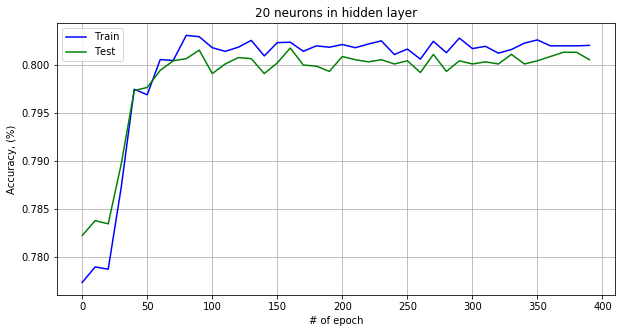

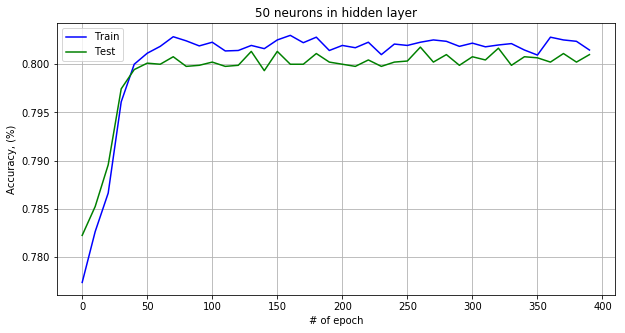

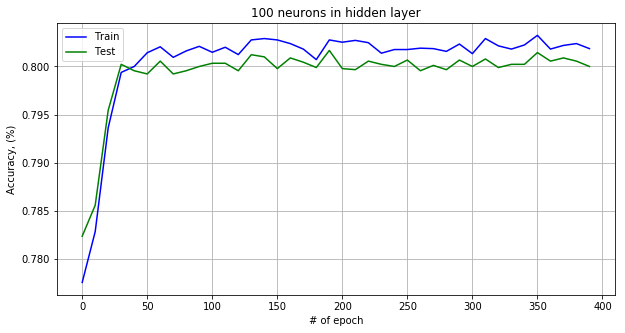

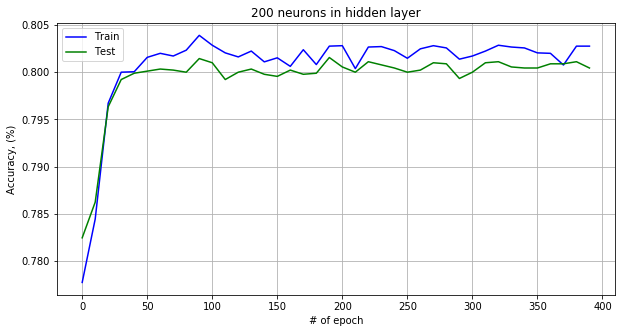

In [26]:
for i in range(len(neurons)):
    epoch = np.arange(0,n_runs*step_iter,step_iter)

    fig = plt.figure(figsize=(10, 5))
    ax = plt.subplot(111)
    ax.plot(epoch, res_train[i], color="blue", label='Train')
    ax.plot(epoch, res_predict[i], color="green", label='Test')

    # ax.set_xticks(np.arange(0.7,29,1))
    # ax.set_yticks(np.arange(0.75,0.85,0.05))

    plt.ylabel("Accuracy, (%)")
    plt.xlabel("# of epoch")
    plt.title(str(neurons[i]) + " neurons in hidden layer")
    ax.legend()
    plt.grid(True)

    plt.show()

Выводы:
* Модель не переобучается с ростом количества итераций, ошибка на тренинговом дата сете практически совпадает с тестовой
* Видно, что точность предсказания пракчтически не зависит от количества нейроннов в скрытом слое

In [23]:
alpha = [0, 0.0001, 0.001, 0.01, 0.1, 1]
res_train_a = []
res_predict_a = []

step_iter = 10
n_runs = 10

for i in range(len(alpha)):
    res_train_a.append([])
    res_predict_a.append([])
    for j in range(1,n_runs+1):    
        nn = MLPClassifier(hidden_layer_sizes=(100), activation='logistic', batch_size=256, \
                solver='sgd', max_iter=j*step_iter, alpha=alpha[i])
        nn.fit(X_train, y_train)
        res_train_a[i].append(nn.score(X_train, y_train))
        res_predict_a[i].append(nn.score(X_test, y_test)) 

C:\Users\egorsmir\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\egorsmir\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\egorsmir\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\egorsmir\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer

C:\Users\egorsmir\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\egorsmir\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\egorsmir\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\egorsmir\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer

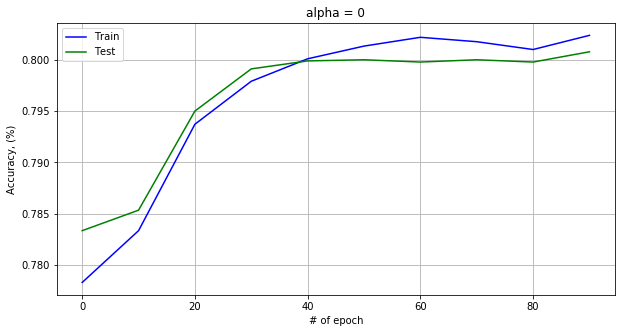

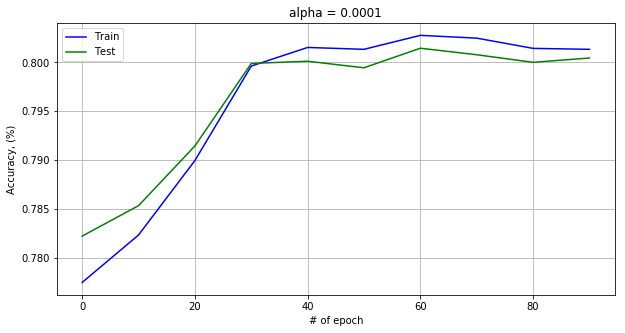

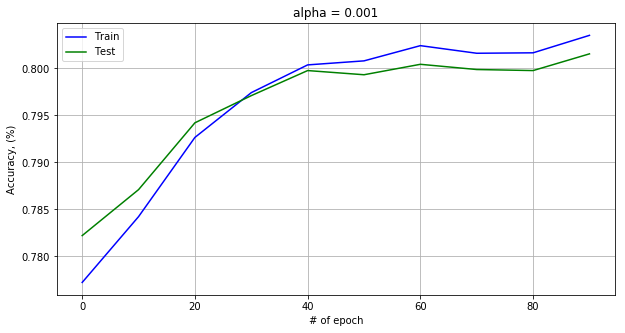

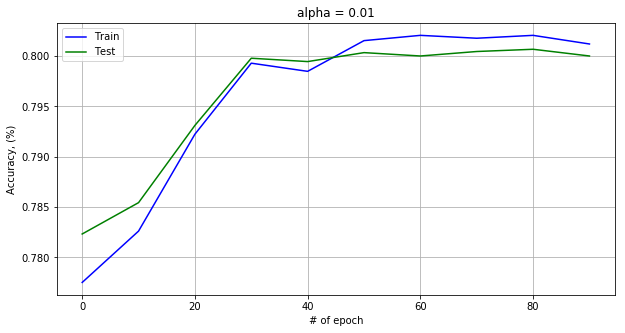

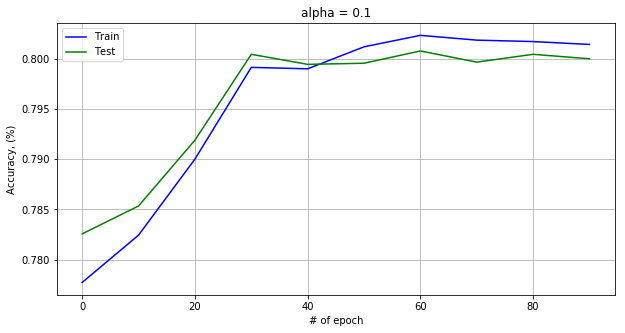

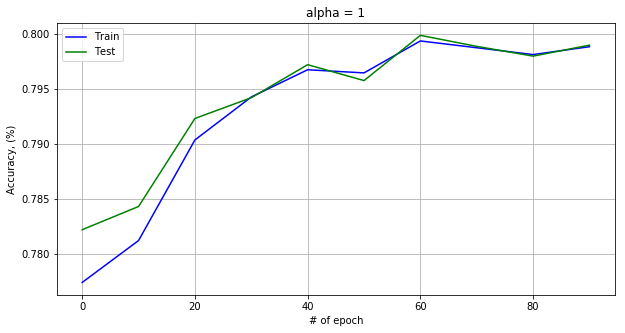

In [24]:
for i in range(len(alpha)):
    epoch = np.arange(0,n_runs*step_iter,step_iter)

    fig = plt.figure(figsize=(10, 5))
    ax = plt.subplot(111)
    ax.plot(epoch, res_train_a[i], color="blue", label='Train')
    ax.plot(epoch, res_predict_a[i], color="green", label='Test')

    # ax.set_xticks(np.arange(0.7,29,1))
    # ax.set_yticks(np.arange(0.75,0.85,0.05))

    plt.ylabel("Accuracy, (%)")
    plt.xlabel("# of epoch")
    plt.title("alpha = " + str(alpha[i]) )
    ax.legend()
    plt.grid(True)

    plt.show()

Для данного дата сета нет значительной разнитцы какой параметр alpha выбирать 

# Лабораторная 3

### Imbalance classes

В исходном дата сете 22.1% ниблюдений, принадлежащих кассу 1 и остальные 77.9% классу 0.
Т.е. у получается несбалансированный набор данных. 
Перед тем, как приступить к 3 лабораторной работе, давайте попробуем решить эту проблему.

Рассмотрим несколько способ решить эт проблему. Наиболее популярные описанны [здесь](https://www.analyticsvidhya.com/blog/2017/03/imbalanced-classification-problem/).
Библитека [imbalance-learn](https://imbalanced-learn.org/en/stable/index.html) содержит готовые алгоритмы, описанные в статье.

Random Over-Sampling и Under-Sampling методы - размножают наблюдения с минорным классом или уменьшают количество набюдений, относящихся к мажорному классу. На практике они не очень эффективны, потому что зачастую обученная модель переобучается. Поэтому пользоваться им мы не будет.

Другой метод, Modified synthetic minority oversampling technique (MSMOTE) - генерирует нблюдения для минорного классу, на основе уже имеющихся. Применим его.

In [2]:
def do_one_hot_encoding(col, data):
    data = pd.concat([pd.get_dummies(data[col], prefix=col), data],axis=1)
    data.drop([col],axis=1, inplace=True)
    return data

def norm(X_train, X_test):
    zscore  = StandardScaler()
    X_train = zscore.fit_transform(X_train)
    X_test  = zscore.transform(X_test)
    return X_train, X_test

def smote(X_train, X_test, y_train, y_test):
    sm = SMOTE(random_state=42)
    X_train, y_train = sm.fit_sample(X_train, y_train)
    return X_train, X_test, y_train, y_test

def load_data():
    df = pd.read_csv("credit_card.csv")
    df = df.drop(columns=['ID'])
    df = df.rename(index=str, columns={"BILL_AMT" + str(i) : "STATE" + str(i)  for i in range(7)})
    df = df.rename(index=str, columns={"PAY_AMT" + str(i) : "PAY" + str(i)  for i in range(7)})
    df = df.rename(index=str, columns={"PAY_" + str(i) : "DELAY" + str(i)  for i in range(7)})
    df = df.rename(index=str, columns={"default payment next month": "label"})
    df = do_one_hot_encoding('SEX', df)
    df = do_one_hot_encoding('EDUCATION', df)
    df = do_one_hot_encoding('MARRIAGE', df)
    
    pca = PCA(n_components = 20, random_state=123)
    data = pca.fit_transform(df.drop('label', axis=1))
    
    X_train, X_test, y_train, y_test = train_test_split(data, np.array(df['label']), test_size=0.3, random_state=42)
    X_train, X_test = norm(X_train, X_test)

    return X_train, X_test, y_train, y_test

In [3]:
def log_reg(X_train, X_test, y_train, y_test):
    log_reg = LogisticRegression(random_state=0, solver='lbfgs', max_iter=1000)
    log_reg.fit(X_train, y_train)
    print("LR train accuracy =", log_reg.score(X_train, y_train))
    print("LR test accuracy  =", log_reg.score(X_test, y_test))
    print("Confusion matrix:", confusion_matrix(y_test, log_reg.predict(X_test)))
    return confusion_matrix(y_test, log_reg.predict(X_test))

def dtree(X_train, X_test, y_train, y_test):
    dtree = tree.DecisionTreeClassifier(max_depth=3)
    dtree.fit(X_train, y_train)

    print("DTREE train accuracy =", dtree.score(X_train, y_train))
    print("DTREE test accuracy  =", dtree.score(X_test, y_test))
    print("Confusion matrix:", confusion_matrix(y_test, dtree.predict(X_test)))

    return confusion_matrix(y_test, dtree.predict(X_test))

def svm(X_train, X_test, y_train, y_test):
    clf = SVC(gamma='auto')
    clf.fit(X_train, y_train)

    print("SVM train accuracy =", clf.score(X_train, y_train))
    print("SVM test accuracy  =", clf.score(X_test, y_test))
    print("Confusion matrix:", confusion_matrix(y_test, clf.predict(X_train)))
    return confusion_matrix(y_test, svm.predict(X_test))

def gbt(X_train, X_test, y_train, y_test):
    gbt = GradientBoostingClassifier(n_estimators=50, max_depth=2)
    gbt.fit(X_train, y_train)
    print("GBT train accuracy =", gbt.score(X_train, y_train))
    print("GBT test accuracy  =", gbt.score(X_test, y_test))
    print("Confusion matrix:", confusion_matrix(y_test, gbt.predict(X_test)))
    return confusion_matrix(y_test, gbt.predict(X_test))

Посмотрим, какие пропорции по классам будут после прменения SMOTE:

In [144]:
X_train, X_test, y_train, y_test = load_data()
X_train, X_test, y_train, y_test = smote(X_train, X_test, y_train, y_test)
pd.DataFrame(y_train).mean()

0    0.5
dtype: float64

Теперь классы абсолютно сбалансированы, это 50% для класса 0 и 50% для класса 1.

Натренируем несколько моделей и выберем с наибольшим аккураси

In [153]:
print(">>>Source:")
X_train, X_test, y_train, y_test = load_data()
log_reg(X_train, X_test, y_train, y_test)
dtree(X_train, X_test, y_train, y_test)
gbt(X_train, X_test, y_train, y_test)

print()
print(">>>SMOTE:")
X_train, X_test, y_train, y_test = smote(X_train, X_test, y_train, y_test)
log_reg(X_train, X_test, y_train, y_test)
dtree(X_train, X_test, y_train, y_test)
gbt(X_train, X_test, y_train, y_test)


>>>Source:
LR train accuracy = 0.8108571428571428
LR test accuracy  = 0.8097777777777778
Confusion matrix: [[6831  209]
 [1503  457]]
DTREE train accuracy = 0.8056190476190476
DTREE test accuracy  = 0.7977777777777778
Confusion matrix: [[6462  578]
 [1242  718]]
GBT train accuracy = 0.8120952380952381
GBT test accuracy  = 0.8083333333333333
Confusion matrix: [[6712  328]
 [1397  563]]

>>>SMOTE:
LR train accuracy = 0.6756003430531733
LR test accuracy  = 0.6792222222222222
Confusion matrix: [[4834 2206]
 [ 681 1279]]
DTREE train accuracy = 0.6790615045332027
DTREE test accuracy  = 0.7624444444444445
Confusion matrix: [[5841 1199]
 [ 939 1021]]
GBT train accuracy = 0.7045454545454546
GBT test accuracy  = 0.7662222222222222
Confusion matrix: [[5750 1290]
 [ 814 1146]]


array([[5750, 1290],
       [ 814, 1146]], dtype=int64)

Лучший аккураси получился у градиентного бустинга, будем рассматривать его.

GBT train accuracy = 0.8120952380952381
GBT test accuracy  = 0.8083333333333333
Confusion matrix: [[6712  328]
 [1397  563]]
GBT train accuracy = 0.7045454545454546
GBT test accuracy  = 0.7662222222222222
Confusion matrix: [[5750 1290]
 [ 814 1146]]


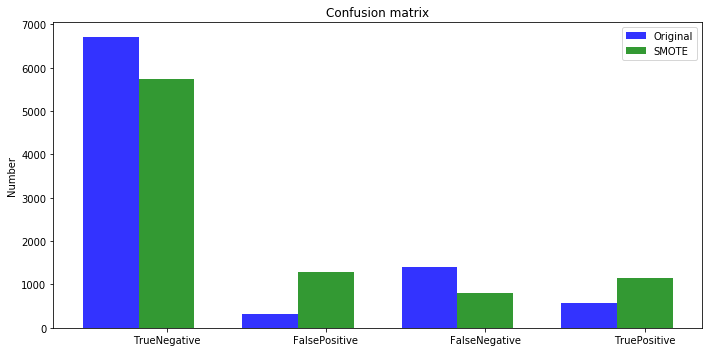

In [154]:
X_train, X_test, y_train, y_test = load_data()
matrix_train = gbt(X_train, X_test, y_train, y_test)
matrix_train = matrix_train.reshape((4,))

X_train, X_test, y_train, y_test = smote(X_train, X_test, y_train, y_test)
matrix_smote = gbt(X_train, X_test, y_train, y_test)
matrix_smote = matrix_smote.reshape((4,))

n_groups = 4
bar_width = 0.35
opacity = 0.8
fig = plt.figure(figsize=(10, 5))
ax = plt.subplot(111)
index = np.arange(n_groups)
rects1 = plt.bar(index, matrix_train, bar_width, alpha=opacity, color='b', label='Original')
rects2 = plt.bar(index + bar_width, matrix_smote, bar_width, alpha=opacity, color='g', label='SMOTE')
plt.xticks(index + bar_width, ["TrueNegative", "FalsePositive", "FalseNegative", "TruePositive"])
plt.legend()
plt.title('Confusion matrix')
plt.ylabel('Number')
plt.tight_layout()
plt.show()

Видно, что количество TruePositive увеличилось в 2 раза, однако и количество FalsePositive сильно увеличлось. Теперь модель может предсказывать значительно лучше позитивные исходы, однако общяя точность упала - с 80.8% до 76.6%.

Допустим, нам не столько важно аккураси как предсказывать TruePositive.
Будем все следующие модели тренировать предворительно применив SMOTE.

Существует еще один способ того, как можно работать с не сбалансированными данными - [balanced random forest](http://statistics.berkeley.edu/sites/default/files/tech-reports/666.pdf)

Он так же присутсвует в imbalance-learn.

In [151]:
def brf(X_train, X_test, y_train, y_test):
    brf = BalancedRandomForestClassifier(n_estimators=100, random_state=0)
    brf.fit(X_train, y_train)
    print("brf train accuracy =", brf.score(X_train, y_train))
    print("brf test accuracy  =", brf.score(X_test, y_test))
    print(confusion_matrix(y_test, brf.predict(X_test)))
    return confusion_matrix(y_test, brf.predict(X_test))

GBT train accuracy = 0.8120952380952381
GBT test accuracy  = 0.8083333333333333
Confusion matrix: [[6712  328]
 [1397  563]]
brf train accuracy = 0.8878095238095238
brf test accuracy  = 0.7342222222222222
[[5352 1688]
 [ 704 1256]]


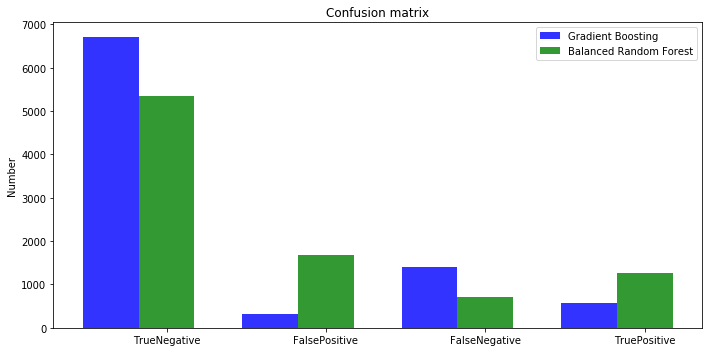

In [155]:
X_train, X_test, y_train, y_test = load_data()
matrix_train = gbt(X_train, X_test, y_train, y_test)
matrix_train = matrix_train.reshape((4,))

matrix_smote = brf(X_train, X_test, y_train, y_test)
matrix_smote = matrix_smote.reshape((4,))

n_groups = 4
bar_width = 0.35
opacity = 0.8
fig = plt.figure(figsize=(10, 5))
ax = plt.subplot(111)
index = np.arange(n_groups)
rects1 = plt.bar(index, matrix_train, bar_width, alpha=opacity, color='b', label='Gradient Boosting')
rects2 = plt.bar(index + bar_width, matrix_smote, bar_width, alpha=opacity, color='g', label='Balanced Random Forest')
plt.xticks(index + bar_width, ["TrueNegative", "FalsePositive", "FalseNegative", "TruePositive"])
plt.legend()
plt.title('Confusion matrix')
plt.ylabel('Number')
plt.tight_layout()
plt.show()

Balanced Random Forest предсказал еще больше TruePositive чем Градиентный Бустинг после SMOTE, однако и показал хуже аккураси.

### Balanced random forest

Проанализируем как влияет количество деревьев в лесу на ошибку прдесказания.

In [157]:
def brf_(X_train, X_test, y_train, y_test,n_tree):
    brf = BalancedRandomForestClassifier(n_estimators=n_tree, random_state=0)
    brf.fit(X_train, y_train)
    return confusion_matrix(y_train, brf.predict(X_train)), confusion_matrix(y_test, brf.predict(X_test)), 

In [171]:
n_tree = [1,2,5,10,20,40,50,100,200]
res_train_cm = []
res_predict_cm = []

X_train, X_test, y_train, y_test = load_data()

for i in range(len(n_tree)):
    cm_train, cm_test = brf_(X_train, X_test, y_train, y_test, n_tree[i])
    res_train_cm.append(cm_train)
    res_predict_cm.append(cm_test)

In [173]:
train_tn = np.array([i[0][0] for i in res_train_cm ])
train_tp = np.array([i[1][1] for i in res_train_cm ])

n_positive = np.count_nonzero(y_train)
n_neg = len(y_train) - n_positive
train_tn = (train_tn / n_neg)*100
train_tp = (train_tp / n_positive)*100

predcit_tn = np.array([i[0][0] for i in res_predict_cm ])
predcit_tp = np.array([i[1][1] for i in res_predict_cm ])

n_positive = np.count_nonzero(y_test)
n_neg = len(y_test) - n_positive
predcit_tn = (predcit_tn / n_neg)*100
predcit_tp = (predcit_tp / n_positive)*100

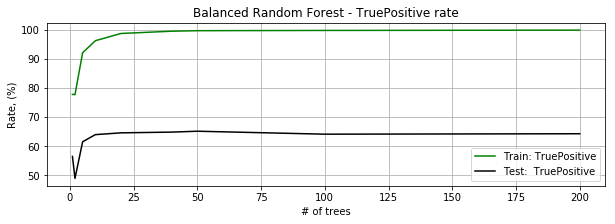

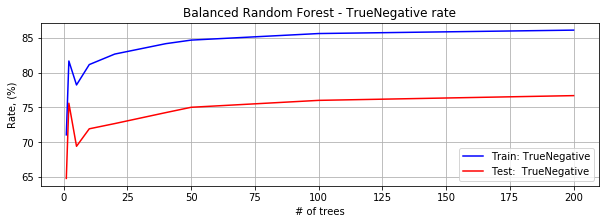

In [180]:
fig = plt.figure(figsize=(10, 3))
ax = plt.subplot(111)
ax.plot(n_tree, train_tp, color="green",   label='Train: TruePositive')
ax.plot(n_tree, predcit_tp, color="black", label='Test:  TruePositive')

plt.ylabel("Rate, (%)")
plt.xlabel("# of trees")
plt.title("Balanced Random Forest - TruePositive rate")
ax.legend()
plt.grid(True)

plt.show()

fig = plt.figure(figsize=(10, 3))
ax = plt.subplot(111)
ax.plot(n_tree, train_tn, color="blue",  label='Train: TrueNegative')
ax.plot(n_tree, predcit_tn, color="red", label='Test:  TrueNegative')

plt.ylabel("Rate, (%)")
plt.xlabel("# of trees")
plt.title("Balanced Random Forest - TrueNegative rate")
ax.legend()
plt.grid(True)

plt.show()

Видно, что Balanced Random Forest переобучается на любом количестве деревьев в модели. Однако с увеличением количества деревьев - качество предсказания увеличивается.

### Random forest

In [185]:
from sklearn.ensemble import RandomForestClassifier
def rf_(X_train, X_test, y_train, y_test,n_tree):
    rf = RandomForestClassifier(n_estimators=n_tree, random_state=0, oob_score=True)
    rf.fit(X_train, y_train)
    return confusion_matrix(y_train, rf.predict(X_train)), confusion_matrix(y_test, rf.predict(X_test)), rf.oob_score_

In [205]:
n_tree = [1,2,5,10,20,40,50,100,200]
res_train_cm = []
res_predict_cm = []
res_oob = []

X_train, X_test, y_train, y_test = load_data()

for i in range(len(n_tree)):
    cm_train, cm_test, obb = rf_(X_train, X_test, y_train, y_test, n_tree[i])
    res_train_cm.append(cm_train)
    res_predict_cm.append(cm_test)
    res_oob.append(obb)

C:\Users\egorsmir\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:460: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\egorsmir\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:465: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
C:\Users\egorsmir\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:460: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\egorsmir\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:465: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
C:\Users\egorsmir\AppData\Local\

In [209]:
train_tn = np.array([i[0][0] for i in res_train_cm ])
train_tp = np.array([i[1][1] for i in res_train_cm ])

n_positive = np.count_nonzero(y_train)
n_neg = len(y_train) - n_positive
train_tn = (train_tn / n_neg)*100
train_tp = (train_tp / n_positive)*100

predcit_tn = np.array([i[0][0] for i in res_predict_cm ])
predcit_tp = np.array([i[1][1] for i in res_predict_cm ])

n_positive = np.count_nonzero(y_test)
n_neg = len(y_test) - n_positive
predcit_tn = (predcit_tn / n_neg)*100
predcit_tp = (predcit_tp / n_positive)*100

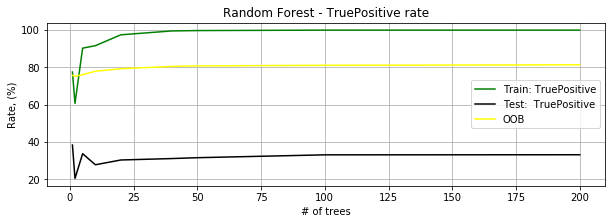

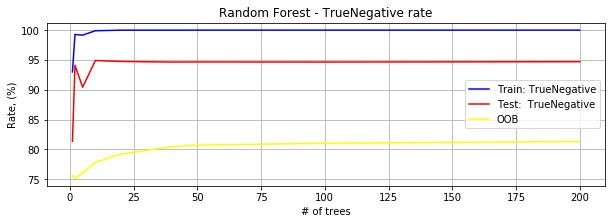

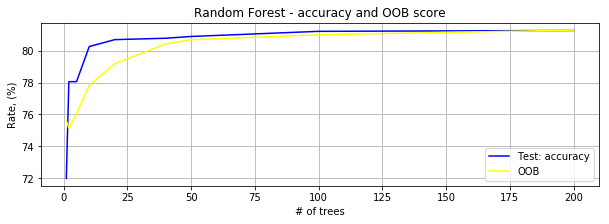

In [210]:
fig = plt.figure(figsize=(10, 3))
ax = plt.subplot(111)
ax.plot(n_tree, train_tp, color="green",   label='Train: TruePositive')
ax.plot(n_tree, predcit_tp, color="black", label='Test:  TruePositive')
ax.plot(n_tree, np.array(res_oob) * 100, color="yellow", label='OOB')

plt.ylabel("Rate, (%)")
plt.xlabel("# of trees")
plt.title("Random Forest - TruePositive rate")
ax.legend()
plt.grid(True)

plt.show()

fig = plt.figure(figsize=(10, 3))
ax = plt.subplot(111)
ax.plot(n_tree, train_tn, color="blue",  label='Train: TrueNegative')
ax.plot(n_tree, predcit_tn, color="red", label='Test:  TrueNegative')
ax.plot(n_tree, np.array(res_oob) * 100, color="yellow", label='OOB')

plt.ylabel("Rate, (%)")
plt.xlabel("# of trees")
plt.title("Random Forest - TrueNegative rate")
ax.legend()
plt.grid(True)
plt.show()

fig = plt.figure(figsize=(10, 3))
ax = plt.subplot(111)

predcit_tn = np.array([i[0][0] for i in res_predict_cm ])
predcit_tp = np.array([i[1][1] for i in res_predict_cm ])
acc = ((predcit_tn + predcit_tp) / len(y_test))*100

ax.plot(n_tree, acc, color="blue",  label='Test: accuracy')
ax.plot(n_tree, np.array(res_oob) * 100, color="yellow", label='OOB')

plt.ylabel("Rate, (%)")
plt.xlabel("# of trees")
plt.title("Random Forest - accuracy and OOB score")
ax.legend()
plt.grid(True)
plt.show()


Видно, что RF как BRF переобучается на на любом количестве деревьев.
OOB score при увеличении количества деревьев стремится к ошибке на тестовом дата сете.

### Extremely random forest

In [214]:
from sklearn.ensemble import ExtraTreesClassifier
def erf_(X_train, X_test, y_train, y_test,n_tree):
    erf = ExtraTreesClassifier(n_estimators=n_tree, random_state=0, oob_score=True, bootstrap=True)
    erf.fit(X_train, y_train)
    return confusion_matrix(y_train, erf.predict(X_train)), confusion_matrix(y_test, erf.predict(X_test)), erf.oob_score_

In [215]:
n_tree = [1,2,5,10,20,40,50,100,200]
res_train_cm = []
res_predict_cm = []
res_oob = []

X_train, X_test, y_train, y_test = load_data()

for i in range(len(n_tree)):
    cm_train, cm_test, obb = erf_(X_train, X_test, y_train, y_test, n_tree[i])
    res_train_cm.append(cm_train)
    res_predict_cm.append(cm_test)
    res_oob.append(obb)

C:\Users\egorsmir\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:460: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\egorsmir\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:465: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
C:\Users\egorsmir\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:460: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\egorsmir\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:465: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
C:\Users\egorsmir\AppData\Local\

In [216]:
train_tn = np.array([i[0][0] for i in res_train_cm ])
train_tp = np.array([i[1][1] for i in res_train_cm ])

n_positive = np.count_nonzero(y_train)
n_neg = len(y_train) - n_positive
train_tn = (train_tn / n_neg)*100
train_tp = (train_tp / n_positive)*100

predcit_tn = np.array([i[0][0] for i in res_predict_cm ])
predcit_tp = np.array([i[1][1] for i in res_predict_cm ])

n_positive = np.count_nonzero(y_test)
n_neg = len(y_test) - n_positive
predcit_tn = (predcit_tn / n_neg)*100
predcit_tp = (predcit_tp / n_positive)*100

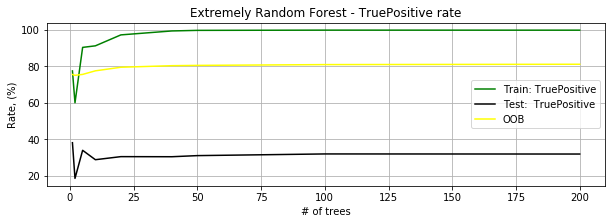

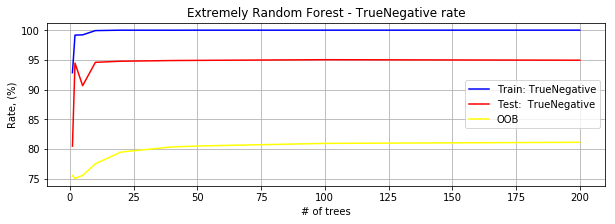

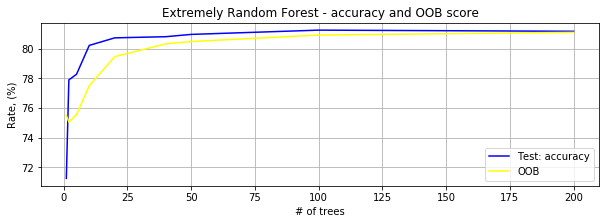

In [217]:
fig = plt.figure(figsize=(10, 3))
ax = plt.subplot(111)
ax.plot(n_tree, train_tp, color="green",   label='Train: TruePositive')
ax.plot(n_tree, predcit_tp, color="black", label='Test:  TruePositive')
ax.plot(n_tree, np.array(res_oob) * 100, color="yellow", label='OOB')

plt.ylabel("Rate, (%)")
plt.xlabel("# of trees")
plt.title("Extremely Random Forest - TruePositive rate")
ax.legend()
plt.grid(True)

plt.show()

fig = plt.figure(figsize=(10, 3))
ax = plt.subplot(111)
ax.plot(n_tree, train_tn, color="blue",  label='Train: TrueNegative')
ax.plot(n_tree, predcit_tn, color="red", label='Test:  TrueNegative')
ax.plot(n_tree, np.array(res_oob) * 100, color="yellow", label='OOB')

plt.ylabel("Rate, (%)")
plt.xlabel("# of trees")
plt.title("Extremely Random Forest - TrueNegative rate")
ax.legend()
plt.grid(True)
plt.show()

fig = plt.figure(figsize=(10, 3))
ax = plt.subplot(111)

predcit_tn = np.array([i[0][0] for i in res_predict_cm ])
predcit_tp = np.array([i[1][1] for i in res_predict_cm ])
acc = ((predcit_tn + predcit_tp) / len(y_test))*100

ax.plot(n_tree, acc, color="blue",  label='Test: accuracy')
ax.plot(n_tree, np.array(res_oob) * 100, color="yellow", label='OOB')

plt.ylabel("Rate, (%)")
plt.xlabel("# of trees")
plt.title("Extremely Random Forest - accuracy and OOB score")
ax.legend()
plt.grid(True)
plt.show()

Extremely Random Forest показал те же результаты, что и обычный Random Forest

### Gradient Boosting

In [245]:
def prepare(res_train_cm, res_predict_cm):
    train_tn = np.array([i[0][0] for i in res_train_cm ])
    train_tp = np.array([i[1][1] for i in res_train_cm ])

    n_positive = np.count_nonzero(y_train)
    n_neg = len(y_train) - n_positive
    train_tn = (train_tn / n_neg)*100
    train_tp = (train_tp / n_positive)*100

    predcit_tn = np.array([i[0][0] for i in res_predict_cm ])
    predcit_tp = np.array([i[1][1] for i in res_predict_cm ])

    n_positive = np.count_nonzero(y_test)
    n_neg = len(y_test) - n_positive
    predcit_tn = (predcit_tn / n_neg)*100
    predcit_tp = (predcit_tp / n_positive)*100

    predcit_tn_acc = np.array([i[0][0] for i in res_predict_cm ])
    predcit_tp_acc = np.array([i[1][1] for i in res_predict_cm ])
    acc_test = ((predcit_tn_acc + predcit_tp_acc) / len(y_test))*100
    
    train_tn_acc = np.array([i[0][0] for i in res_train_cm ])
    train_tp_acc = np.array([i[1][1] for i in res_train_cm ])
    acc_train = ((train_tn_acc + train_tp_acc) / len(y_train))*100
    
    return train_tn, train_tp, predcit_tn, predcit_tp, acc_train, acc_test

def drow(train_tn, train_tp, predcit_tn, predcit_tp, acc_train, acc_test, Alg):
    fig = plt.figure(figsize=(10, 3))
    ax = plt.subplot(111)
    ax.plot(n_tree, train_tp, color="green",   label='Train: TruePositive')
    ax.plot(n_tree, predcit_tp, color="black", label='Test:  TruePositive')

    plt.ylabel("Rate, (%)")
    plt.xlabel("# of trees")
    plt.title(Alg + " - TruePositive rate")
    ax.legend()
    plt.grid(True)

    plt.show()

    fig = plt.figure(figsize=(10, 3))
    ax = plt.subplot(111)
    ax.plot(n_tree, train_tn, color="blue",  label='Train: TrueNegative')
    ax.plot(n_tree, predcit_tn, color="red", label='Test:  TrueNegative')

    plt.ylabel("Rate, (%)")
    plt.xlabel("# of trees")
    plt.title(Alg + " - TrueNegative rate")
    ax.legend()
    plt.grid(True)

    plt.show()

    fig = plt.figure(figsize=(10, 3))
    ax = plt.subplot(111)
    
    ax.plot(n_tree, acc_train, color="blue",  label='Train: accuracy')
    ax.plot(n_tree, acc_test,  color="green",  label='Test: accuracy')

    plt.ylabel("Rate, (%)")
    plt.xlabel("# of trees")
    plt.title(Alg + " - accuracy")
    ax.legend()
    plt.grid(True)
    plt.show()


Посмотрим какие результаты выдаст Градиентный Бустинг на исходном дата сете

In [246]:
def gbt_(X_train, X_test, y_train, y_test,n_tree):
    gbt = GradientBoostingClassifier(n_estimators=n_tree, random_state=0)
    gbt.fit(X_train, y_train)
    return confusion_matrix(y_train, gbt.predict(X_train)), confusion_matrix(y_test, gbt.predict(X_test))

n_tree = [1,2,10,50,75,100,150,200, 300]
res_train_cm = []
res_predict_cm = []

X_train, X_test, y_train, y_test = load_data()
for i in range(len(n_tree)):
    cm_train, cm_test = gbt_(X_train, X_test, y_train, y_test, n_tree[i])
    res_train_cm.append(cm_train)
    res_predict_cm.append(cm_test)

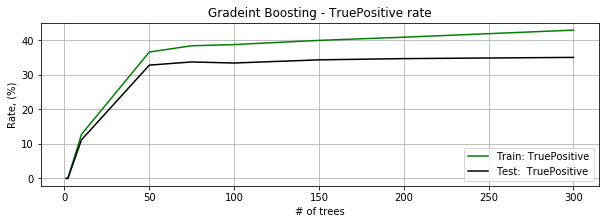

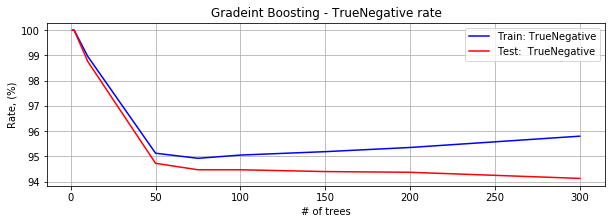

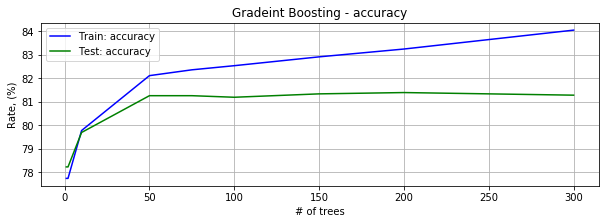

In [247]:
train_tn, train_tp, predcit_tn, predcit_tp, acc_train, acc_test = prepare(res_train_cm, res_predict_cm)
drow(train_tn, train_tp, predcit_tn, predcit_tp, acc_train, acc_test, "Gradeint Boosting")

Видно, что примерно на 50 деревьях - Градиентный Бустинг начинает переобучаться. Точность на тестовом дата сете при этом перестает расти.

Применим SMOTE к дата сету и посмотрим результаты

In [248]:
def gbt_(X_train, X_test, y_train, y_test,n_tree):
    gbt = GradientBoostingClassifier(n_estimators=n_tree, random_state=0)
    gbt.fit(X_train, y_train)
    return confusion_matrix(y_train, gbt.predict(X_train)), confusion_matrix(y_test, gbt.predict(X_test))

n_tree = [1,2,10,50,75,100,150,200,300]
res_train_cm = []
res_predict_cm = []

X_train, X_test, y_train, y_test = load_data()
X_train, X_test, y_train, y_test = smote(X_train, X_test, y_train, y_test)
for i in range(len(n_tree)):
    cm_train, cm_test = gbt_(X_train, X_test, y_train, y_test, n_tree[i])
    res_train_cm.append(cm_train)
    res_predict_cm.append(cm_test)

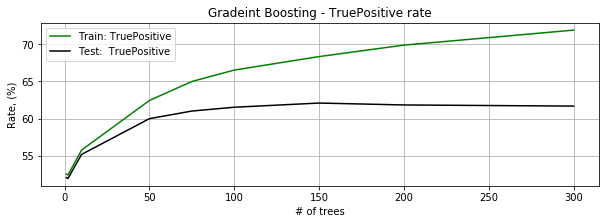

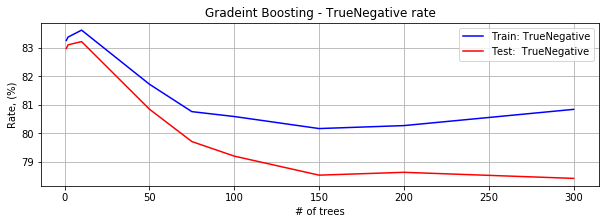

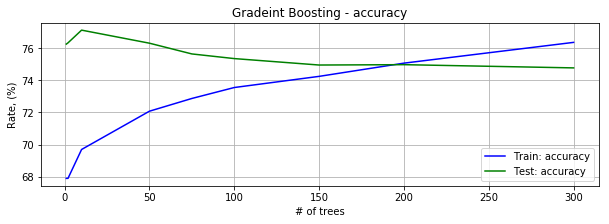

In [249]:
train_tn, train_tp, predcit_tn, predcit_tp, acc_train, acc_test = prepare(res_train_cm, res_predict_cm)
drow(train_tn, train_tp, predcit_tn, predcit_tp, acc_train, acc_test, "Gradeint Boosting")

Здесь видно, что при увеличении количества деревьев точность модель на тестовых данных начинает снижаться.
При этом TruePositive останавлиает свой рост на 100 деревьях.

### AdaBoost

Проделаем все тоже самое с AdaBoost, что и делали с Градиентным бустингом.

In [251]:
from sklearn.ensemble import AdaBoostClassifier
def adb_(X_train, X_test, y_train, y_test,n_tree):
    adb = AdaBoostClassifier(n_estimators=n_tree, random_state=0)
    adb.fit(X_train, y_train)
    return confusion_matrix(y_train, adb.predict(X_train)), confusion_matrix(y_test, adb.predict(X_test))

n_tree = [1,2,10,50,100,200]
res_train_cm = []
res_predict_cm = []

X_train, X_test, y_train, y_test = load_data()
for i in range(len(n_tree)):
    cm_train, cm_test = adb_(X_train, X_test, y_train, y_test, n_tree[i])
    res_train_cm.append(cm_train)
    res_predict_cm.append(cm_test)

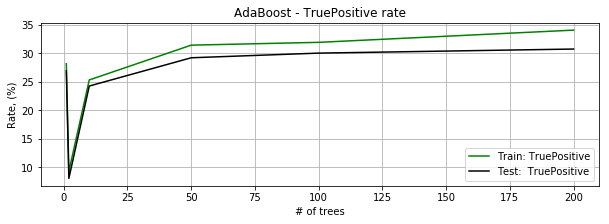

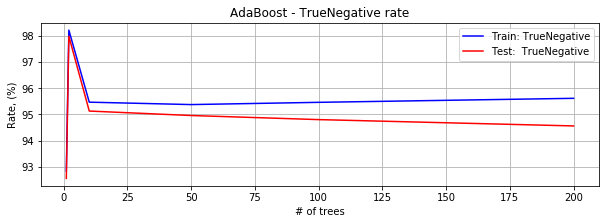

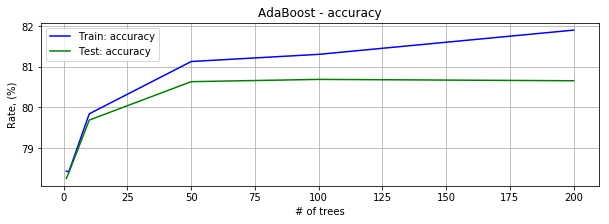

In [252]:
train_tn, train_tp, predcit_tn, predcit_tp, acc_train, acc_test = prepare(res_train_cm, res_predict_cm)
drow(train_tn, train_tp, predcit_tn, predcit_tp, acc_train, acc_test, "AdaBoost")

На 50+ деревьях точность остается постоянной на тестовых данных

In [253]:
from sklearn.ensemble import AdaBoostClassifier
def adb_(X_train, X_test, y_train, y_test,n_tree):
    adb = AdaBoostClassifier(n_estimators=n_tree, random_state=0)
    adb.fit(X_train, y_train)
    return confusion_matrix(y_train, adb.predict(X_train)), confusion_matrix(y_test, adb.predict(X_test))

n_tree = [1,2,10,50,100,200]
res_train_cm = []
res_predict_cm = []

X_train, X_test, y_train, y_test = load_data()
X_train, X_test, y_train, y_test = smote(X_train, X_test, y_train, y_test)
for i in range(len(n_tree)):
    cm_train, cm_test = adb_(X_train, X_test, y_train, y_test, n_tree[i])
    res_train_cm.append(cm_train)
    res_predict_cm.append(cm_test)

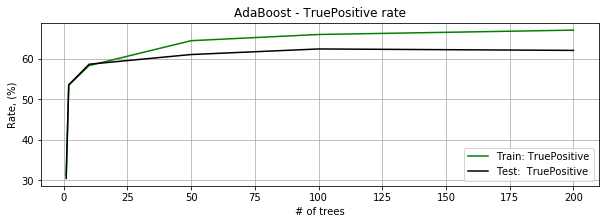

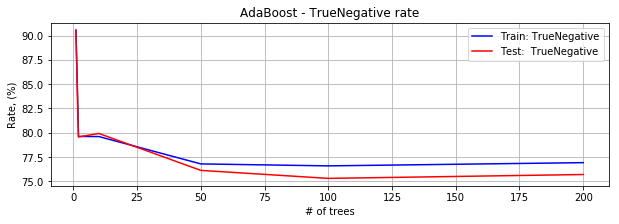

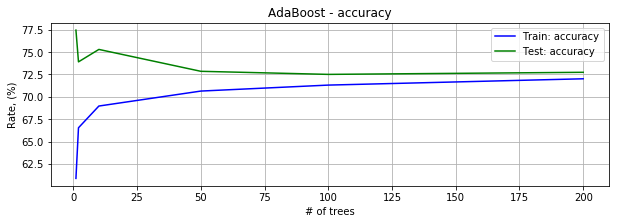

In [254]:
train_tn, train_tp, predcit_tn, predcit_tp, acc_train, acc_test = prepare(res_train_cm, res_predict_cm)
drow(train_tn, train_tp, predcit_tn, predcit_tp, acc_train, acc_test, "AdaBoost")

Точность на тестовых данных и тренировачных - одинаковая при большом количестве деревьев, модель - не переобучается, в отличие от других моделей.
Однако точность ее меньше, чем у Градиентного Бувтинга.

# Лабораторная 4

PCA был рассмотрен в первой лабораторной работе, сейчас давайте посмотрим как будет изменяться ошибка на тренировочных и тестовых данных.

In [11]:
def do_one_hot_encoding(col, data):
    data = pd.concat([pd.get_dummies(data[col], prefix=col), data],axis=1)
    data.drop([col],axis=1, inplace=True)
    return data

def norm(X_train, X_test):
    zscore  = StandardScaler()
    X_train = zscore.fit_transform(X_train)
    X_test  = zscore.transform(X_test)
    return X_train, X_test

def load_data():
    df = pd.read_csv("credit_card.csv")
    df = df.drop(columns=['ID'])
    df = df.rename(index=str, columns={"BILL_AMT" + str(i) : "STATE" + str(i)  for i in range(7)})
    df = df.rename(index=str, columns={"PAY_AMT" + str(i) : "PAY" + str(i)  for i in range(7)})
    df = df.rename(index=str, columns={"PAY_" + str(i) : "DELAY" + str(i)  for i in range(7)})
    df = df.rename(index=str, columns={"default payment next month": "label"})
    df = do_one_hot_encoding('SEX', df)
    df = do_one_hot_encoding('EDUCATION', df)
    df = do_one_hot_encoding('MARRIAGE', df)
    
    X_train, X_test, y_train, y_test = train_test_split(df.drop('label', axis=1), np.array(df['label']), test_size=0.3, random_state=42)
    X_train, X_test = norm(X_train, X_test)

    return X_train, X_test, y_train, y_test

In [12]:
X_train, X_test, y_train, y_test = load_data()

C:\Users\egorsmir\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:617: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\egorsmir\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
C:\Users\egorsmir\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  if __name__ == '__main__':


In [13]:
X_train.shape

(21000, 33)

Что бы подобрать оптимальное количество компонент - воспользуемся способом описанным здесь: https://jakevdp.github.io/PythonDataScienceHandbook/05.09-principal-component-analysis.html

Нам нужно подсчитатать кумулятивную сумму вариации по компонентам.

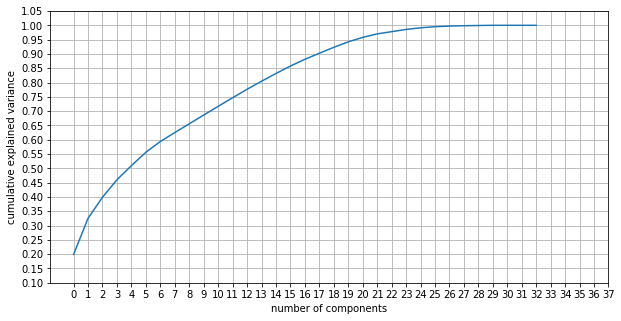

In [14]:
pca = PCA().fit(X_train)
fig = plt.figure(figsize=(10, 5))
ax = plt.subplot(111)
ax.plot(np.cumsum(pca.explained_variance_ratio_))
ax.set_xticks(np.arange(0,38,1))
ax.set_yticks(np.arange(0.1,1.1,0.05))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');
plt.grid(True)

In [30]:
def log_reg_(X_train, X_test, y_train, y_test,n_components):
    pca = PCA(n_components=n_components).fit(X_train)
    X_train_pca = pca.transform(X_train)
    X_test_pca = pca.transform(X_test)
    lr = LogisticRegression(random_state=0, solver='lbfgs')
    lr.fit(X_train_pca, y_train)
    
    return lr.score(X_train_pca, y_train), lr.score(X_test_pca, y_test)

n_components = np.arange(1,32)
res_train_cm = []
res_predict_cm = []

X_train, X_test, y_train, y_test = load_data()
for i in range(len(n_components)):
    cm_train, cm_test = log_reg_(X_train, X_test, y_train, y_test, n_components[i])
    res_train_cm.append(cm_train)
    res_predict_cm.append(cm_test)

C:\Users\egorsmir\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:617: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\egorsmir\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
C:\Users\egorsmir\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  if __name__ == '__main__':


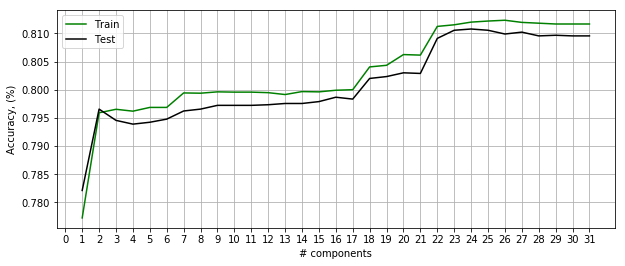

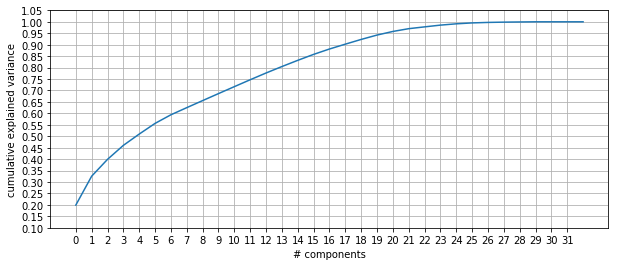

In [47]:
fig = plt.figure(figsize=(10, 4))
ax = plt.subplot(111)
ax.plot(np.arange(1,32), res_train_cm, color="green",   label='Train')
ax.plot(np.arange(1,32), res_predict_cm, color="black", label='Test')

plt.ylabel("Accuracy, (%)")
plt.xlabel("# components")
plt.title("")
ax.set_xticks(np.arange(0,32,1))
ax.legend()
plt.grid(True)

plt.show()

pca = PCA().fit(X_train)
fig = plt.figure(figsize=(10, 4))
ax = plt.subplot(111)
ax.plot(np.cumsum(pca.explained_variance_ratio_))
ax.set_xticks(np.arange(0,32,1))
ax.set_yticks(np.arange(0.1,1.1,0.05))
plt.xlabel('# components')
plt.ylabel('cumulative explained variance');
plt.grid(True)

Видно, что кумулятивная сумма вариации становится равна ~1 при 24 компонентах.
Тестовая ошибка достигает своего минимума как раз при 24 компонентах. Дальше, она слегка увеличивается, т.е. модель переобучается.

Делаем вывод
- если мы выбираем такое количество компонент, при котороми кумулятивная сумма вариации < 1 - возможна потеря точности подели
- когда кумулятивная сумма вариации -> 1, дальнейшее увеличение количества компонент, может только ухудшить качество предсказания, т.к. количество зависимых признаков увеличивается, это может привести к усложнению модели. 